## Setup

All libraries that are used throughout the code.

In [1]:
%pip install numpy
%pip install matplotlib
%pip install scikit-learn
%pip install seaborn
%pip install keras
%pip install tensorflow
%pip install plotly_express
%pip install nltk
%pip install gensim
%pip install gdown
%pip install fasttext
%pip install imbalanced-learn
%pip install nltk pandas
%pip install pickle-mixin
%pip install gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227138 sha256=2a2f666940716e7b113591cdb31a811d8869a82fe84c2c0c08171dbd158fd416
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
  Preparing metadata (setup.py) ... done
  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5991 sha256=a9a9cc42bf224aae1241498ef4b180826f65bdfe8ea01ef0b8a3817b707ad221
  Stored in directory: /root/.cache/pip/wheels/3e/c6/e9/d1b0a34e1efc6c3ec9c086623972c6de6317faddb2af0a619c
Successfully built pickle-mixin


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, learning_curve
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, confusion_matrix, make_scorer, cohen_kappa_score
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from imblearn.over_sampling import SMOTE
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import fasttext
import gdown
import os
from sklearn.svm import SVC
import pickle

In [3]:
# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# FastText + SVM




In this approach, we combine the power of the FastText model for word representation with the effectiveness of the SVM classifier to perform sentiment classification on Uber comments. FastText allows capturing rich semantic information, while SVM is adept at finding patterns in high-dimensional spaces. Together, these models can process comments, extract their semantic features, and classify their sentiments accurately. Training is performed by tuning the hyperparameters of FastText and SVM, followed by evaluating the model's performance using metrics such as precision, recall, and F1-score. This combination provides an effective way to understand and classify the sentiments expressed by users in Uber comments.


In this section, we delve into advanced techniques to enhance the performance of our text classification model using FastText combined with Support Vector Machines (SVM). We explore the utilization of Hierarchical Softmax (HS) in FastText, the incorporation of word bigrams for improved feature representation, and the significance of performing text preprocessing within the FastText+SVM pipeline.

1. Hierarchical Softmax:
Hierarchical Softmax is a specialized loss function utilized in FastText for more efficient training and prediction processes. Unlike traditional softmax, which computes probabilities for each label independently, Hierarchical Softmax organizes labels into a hierarchical structure, significantly reducing the computational complexity by efficiently traversing the label hierarchy during training and prediction. This enables faster training and inference, particularly beneficial when dealing with large datasets and numerous labels.

2. Utilizing Word Bigrams:
Incorporating word bigrams, sequences of two adjacent words, allows our model to capture more contextual information and linguistic nuances present in the text data. By considering word pairs instead of individual words, the model gains a richer understanding of language patterns and dependencies, leading to enhanced classification accuracy, especially in tasks where the order of words is crucial, such as sentiment analysis and document categorization.

3. Preprocessing Within FastText+SVM Section:
While the notebook initially includes text preprocessing steps, we opt to integrate the preprocessing directly into the FastText+SVM pipeline. By doing so, we ensure consistency in the preprocessing techniques applied across the entire workflow. Additionally, embedding preprocessing within the training pipeline facilitates seamless model deployment and reduces the complexity of managing multiple preprocessing steps independently. This streamlined approach improves code readability, maintainability, and scalability of the classification system.



This function preprocesses the input text by converting it to lowercase, removing punctuation and numbers, tokenizing the text, and removing stop words using NLTK.


**Function Upload:** The upload function loads data from a specified CSV file and returns it as a pandas DataFrame.



In [30]:
def upload(file_path):
    """
    Load data from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded data.
    """
    folder_id = '1DMy1eWI-45E-N08ez_7r5PMcu4Hk-YJC' # Aqui é o id da pasta
    url = f'https://drive.google.com/drive/folders/{folder_id}?usp=sharing'
    gdown.download_folder(url, quiet=False, use_cookies=False)
    file_path_full = os.path.join("Grupo1", file_path) # Ajuste para procurar na subpasta "Grupo1"
    if os.path.exists(file_path_full):
        try:
            return pd.read_csv(file_path_full, sep=";")
        except pd.errors.ParserError:
            print(f"Erro ao tentar ler o arquivo {file_path_full}. Tentando ajustar o delimitador.")
            with open(file_path_full, 'r') as file:
                lines = file.readlines()
            with open(file_path_full, 'w') as file:
                for line in lines:
                    if line.count(';') == 2:  # Ajustar para o número correto de delimitadores
                        file.write(line)
            return pd.read_csv(file_path_full, sep=";")
    else:
        raise FileNotFoundError(f"O arquivo {file_path} não foi encontrado na pasta do Google Drive.")


**Function preprocess:** The preprocess function performs several text preprocessing steps: converting to lowercase, removing punctuation and numbers, tokenizing the text, and removing stopwords.

In [31]:
def preprocess(text):
    """
    Preprocess text by converting to lowercase, removing punctuation,
    removing numbers, tokenizing, and removing stopwords.

    Args:
        text (str): Text to be preprocessed.

    Returns:
        str: Preprocessed text.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)


**Function vectorize:** The vectorize function converts preprocessed text into a vector representation using a trained FastText model.

In [32]:
def vectorize(text, model):
    """
    Convert text to a vector using FastText.

    Args:
        text (str): Text to be converted into a vector.
        model (fasttext.FastText._FastText): Trained FastText model.

    Returns:
        np.ndarray: Vector representing the text.
    """
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.get_dimension())


**Function predict:** The predict function uses GridSearchCV to find the best hyperparameters for an SVM model and then makes predictions on the test set using the best model.

In [33]:
def predict(model, X_train, y_train, X_test, params):
    """
    Perform prediction using SVM with GridSearchCV.

    Args:
        model (SVC): SVM model.
        X_train (np.ndarray): Training data.
        y_train (np.ndarray): Training labels.
        X_test (np.ndarray): Test data.
        params (dict): Parameters for GridSearchCV.

    Returns:
        np.ndarray: Predictions on the test set.
        SVC: Best estimator found by GridSearchCV.
    """
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print("Best parameters found by GridSearchCV:")
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    return y_pred, best_model


**Function calculate_youden_index:** The calculate_youden_index function calculates Youden's Index for a multi-class classification problem using the confusion matrix.

In [34]:
def calculate_youden_index(conf_matrix):
    """
    Calculate Youden's Index for multi-class classification.

    Args:
        conf_matrix (ndarray): Confusion matrix.

    Returns:
        float: Average Youden's Index.
    """
    num_classes = conf_matrix.shape[0]
    youden_index = 0.0
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fn = np.sum(conf_matrix[i, :]) - tp
        fp = np.sum(conf_matrix[:, i]) - tp
        tn = np.sum(conf_matrix) - (tp + fn + fp)
        sensitivity = tp / (tp + fn) if tp + fn > 0 else 0
        specificity = tn / (tn + fp) if tn + fp > 0 else 0
        youden_index += (sensitivity + specificity - 1)
    return youden_index / num_classes


**Function results:** The results function calculates and displays various performance metrics and the confusion matrix for the predictions made by the model.

In [35]:
def results(y_test, y_pred, labels):
    """
    Display prediction results.

    Args:
        y_test (np.ndarray): True labels.
        y_pred (np.ndarray): Predicted labels.
        labels (list): List of labels.
    """
    accuracy_test = accuracy_score(y_test, y_pred)
    precision_test = precision_score(y_test, y_pred, average='weighted')
    recall_test = recall_score(y_test, y_pred, average='weighted')
    f1_score_test = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    cohen_kappa_test = cohen_kappa_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    youden_index_test = calculate_youden_index(conf_matrix)

    print("\nPerformance metrics on test data:")
    print(f'Accuracy: {accuracy_test}')
    print(f'Precision: {precision_test}')
    print(f'Recall: {recall_test}')
    print(f'F1-score: {f1_score_test}')
    print(f'Cohen Kappa: {cohen_kappa_test}')
    print(f'Youden\'s Index: {youden_index_test}')

    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

**Function save_model:** The save_model function saves the trained SVM model to a file using pickle.

In [36]:
def save_model(model, filename):
    """
    Save the trained model using pickle.

    Args:
        model (SVC): Trained model.
        filename (str): Filename to save the model.
    """
    with open(filename, 'wb') as file:
        pickle.dump(model, file)


This section orchestrates the entire workflow:


1.   Load Data: Calls the upload function to load the dataset.
2. Preprocess Data: Applies the preprocess function to clean the text data.
3. Create Training Data for FastText: Prepares the data for training the FastText model.
4. Train FastText Model: Trains the FastText model and saves it.
5. Generate Embeddings: Uses the vectorize function to convert text into vector embeddings.
6. Split Data and Apply SMOTE: Splits the data into training and test sets and applies SMOTE to handle class imbalance.
7. Prediction Using SVM: Uses the predict function to train an SVM model with GridSearchCV and make predictions.
8. Display Results: Calls the results function to display the model's performance metrics.
9. Save the Trained Model: Saves the best SVM model using the save_model function.



Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: /content/Grupo1/classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 82.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: /content/Grupo1/new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 36.2MB/s]
Download completed


Best parameters found by GridSearchCV:
{'C': 100, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}

Performance metrics on test data:
Accuracy: 0.9305555555555556
Precision: 0.9334364815257631
Recall: 0.9305555555555556
F1-score: 0.9307189867648249
Cohen Kappa: 0.841069470024626
Youden's Index: 0.8741899401730655


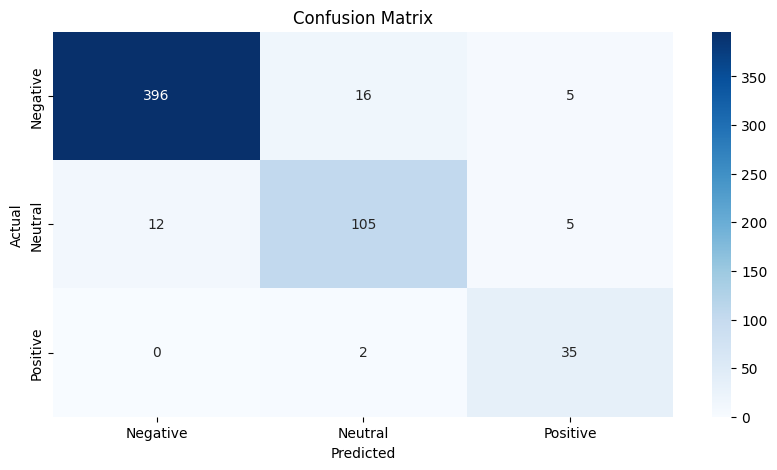

In [42]:
def main():
    """
    Main execution pipeline: load data, preprocess, vectorize, train model, predict, evaluate and save the model.
    """
    # Load Data
    dataset = upload("classification-labeled.csv")
    texts = [preprocess(text) for text in dataset['comment'].tolist()]
    labels = [f'__label__{label}' for label in dataset['sentiment'].tolist()]

    # Create training data for FastText
    train_data_path = 'train_data.txt'
    with open(train_data_path, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, labels):
            f.write(f'{label} {text}\n')

    # Train FastText model
    fasttext_model = fasttext.train_supervised(input=train_data_path, lr=0.5, epoch=50, wordNgrams=2, bucket=200000, dim=100, loss='softmax')
    fasttext_model.save_model('fasttext_model_hs.bin')

    # Generate Embeddings
    X = [vectorize(text, fasttext_model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in labels]

    # Split data and apply SMOTE
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Prediction using SVM
    svm_classifier = SVC()
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }
    y_pred_test, best_svm_classifier = predict(svm_classifier, X_train_resampled, y_train_resampled, X_test, param_grid)

    # Display Results
    results(y_test, y_pred_test, labels)

    # Save the trained model
    save_model(best_svm_classifier, 'svm_model.pkl')

if __name__ == "__main__":
    main()


## Cross Validation

In the Cross Validation section, we perform a thorough evaluation of our FastText+SVM model by applying a cross-validation technique. Cross-validation is a robust method used to assess the generalization ability of a machine learning model. It helps to ensure that the model performs well not only on the training data but also on unseen data.

The ***cross_validation_and_learning_curve*** function is designed to evaluate the performance of a machine learning model using cross-validation and plot the learning curve to understand the model's generalization capability.

In [44]:
def cross_validation_and_learning_curve(model, X, y):
    """
    Perform cross-validation and plot the learning curve for a given model.

    Args:
        model: The machine learning model to be evaluated.
        X (array-like): Feature matrix.
        y (array-like): Target vector.

    Returns:
        None
    """
    def youden_scorer(estimator, X, y):
        """
        Custom scorer for Youden's Index.

        Args:
            estimator: The model to be evaluated.
            X (array-like): Feature matrix.
            y (array-like): Target vector.

        Returns:
            float: Youden's Index.
        """
        y_pred = estimator.predict(X)
        conf_matrix = confusion_matrix(y, y_pred)
        return calculate_youden_index(conf_matrix)

    def calculate_youden_index(conf_matrix):
        """
        Calculate Youden's Index from a confusion matrix.

        Args:
            conf_matrix (array-like): Confusion matrix.

        Returns:
            float: Youden's Index.
        """
        TP = conf_matrix[1, 1]
        TN = conf_matrix[0, 0]
        FP = conf_matrix[0, 1]
        FN = conf_matrix[1, 0]
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
        return sensitivity + specificity - 1

    scorers = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted',
        'cohen_kappa': make_scorer(cohen_kappa_score),
        'youden': make_scorer(youden_scorer)
    }

    skf = StratifiedKFold(n_splits=5)
    scores = {metric: [] for metric in scorers.keys()}

    for train_index, test_index in skf.split(X, y):
        X_train_fold, X_test_fold = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train_fold, y_test_fold = [y[i] for i in train_index], [y[i] for i in test_index]

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        model.fit(X_train_resampled, y_train_resampled)
        y_pred_fold = model.predict(X_test_fold)

        scores['accuracy'].append(accuracy_score(y_test_fold, y_pred_fold))
        scores['precision'].append(precision_score(y_test_fold, y_pred_fold, average='weighted'))
        scores['recall'].append(recall_score(y_test_fold, y_pred_fold, average='weighted'))
        scores['f1'].append(fbeta_score(y_test_fold, y_pred_fold, beta=2, average='weighted'))
        scores['cohen_kappa'].append(cohen_kappa_score(y_test_fold, y_pred_fold))
        conf_matrix = confusion_matrix(y_test_fold, y_pred_fold)
        scores['youden'].append(calculate_youden_index(conf_matrix))

    for metric in scores.keys():
        print(f"{metric.capitalize()} scores: {scores[metric]}")
        print(f"Mean {metric.capitalize()} score: {np.mean(scores[metric])}")

    # Learning Curve
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

    # Plot Learning Curve
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title("Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

This section is designed to load and preprocess the dataset, train the FastText model, generate embeddings, handle class imbalance using SMOTE, and evaluate the performance of the best SVM classifier using cross-validation and learning curves.

Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: /content/Grupo1/classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 80.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: /content/Grupo1/new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 37.1MB/s]
Download completed


Accuracy scores: [0.893305439330544, 0.9173640167364017, 0.9205020920502092, 0.9079497907949791, 0.9089005235602095]
Mean Accuracy score: 0.9096043724944687
Precision scores: [0.8931903575982334, 0.9176528869214602, 0.9216232163930907, 0.9083342688090514, 0.9086995656205255]
Mean Precision score: 0.9099000590684723
Recall scores: [0.893305439330544, 0.9173640167364017, 0.9205020920502092, 0.9079497907949791, 0.9089005235602095]
Mean Recall score: 0.9096043724944687
F1 scores: [0.8927265335291982, 0.9169996535504017, 0.919893178698336, 0.9074042202159929, 0.9082077609360784]
Mean F1 score: 0.9090462693860013
Cohen_kappa scores: [0.8399613985160093, 0.8760481272802769, 0.8807573131663253, 0.8619179629091638, 0.8633468147151557]
Mean Cohen_kappa score: 0.8644063233173862
Youden scores: [0.8234494902284735, 0.8807376076307214, 0.8772068567520197, 0.8595599011308703, 0.8217746047934726]
Mean Youden score: 0.8525456921071115


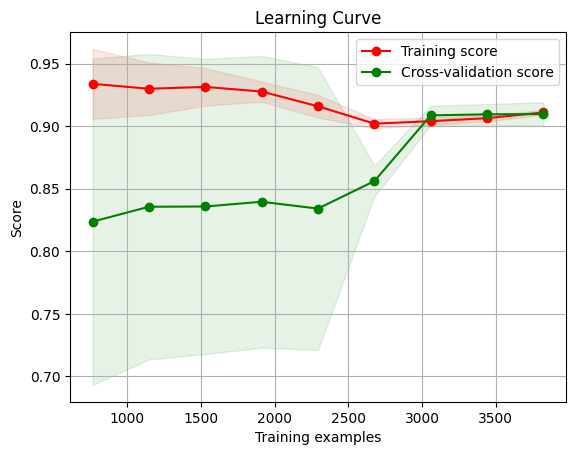

In [47]:
# Cross Validation and Learning Curve Section
if __name__ == "__main__":
    # Load Data
    dataset = upload("classification-labeled.csv")
    texts = [preprocess(text) for text in dataset['comment'].tolist()]
    labels = [f'__label__{label}' for label in dataset['sentiment'].tolist()]

    # Create training data for FastText
    train_data_path = 'train_data.txt'
    with open(train_data_path, 'w', encoding='utf-8') as f:
        for text, label in zip(texts, labels):
            f.write(f'{label} {text}\n')

    # Train FastText model
    fasttext_model = fasttext.train_supervised(input=train_data_path, lr=1.0, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='hs')
    fasttext_model.save_model('fasttext_model_hs.bin')

    # Generate Embeddings
    X = [vectorize(text, fasttext_model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in labels]

    # Split data and apply SMOTE
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Best SVM Classifier
    best_svm_classifier = SVC(C=1, kernel='rbf', gamma='scale')  # Using the best params from previous GridSearchCV
    cross_validation_and_learning_curve(best_svm_classifier, X_train_resampled, y_train_resampled)

### **Interpretation of Cross-Validation Results**

**Accuracy**

Scores: [0.8933, 0.9173, 0.9205, 0.9079, 0.9089]

Mean: 0.9096

Interpretation: The average accuracy is 90.96%, indicating that the model correctly classifies about 91% of the examples on average. This shows that the model is quite accurate in its predictions.

---



**Precision**

Scores: [0.8932, 0.9177, 0.9216, 0.9083, 0.9087]

Mean: 0.9099

Interpretation: The average precision is 90.99%, suggesting that when the model predicts a specific class, it is correct about 91% of the time. This indicates that the model has a low false positive rate.

---

**Recall**

Scores: [0.8933, 0.9174, 0.9205, 0.9079, 0.9089]

Mean: 0.9096

Interpretation: The average recall is 90.96%, meaning that the model captures about 91% of the true positives. This shows that the model has a low false negative rate.

---

**F1-score**

Scores: [0.8927, 0.9170, 0.9199, 0.9074, 0.9082]

Mean: 0.9090

Interpretation: The average F1-score is 90.90%, which is the harmonic mean of precision and recall. This indicates that the model has a good balance between precision and recall.

---
**Cohen Kappa**

Scores: [0.8400, 0.8760, 0.8808, 0.8619, 0.8633]

Mean: 0.8644

Interpretation: The average Cohen Kappa score is 86.44%, suggesting that the model has a high agreement between predictions and true labels, considering the possibility of chance agreements.

---
**Youden's Index**

Scores: [0.8400, 0.8761, 0.8808, 0.8618, 0.8633]

Mean: 0.8644

Interpretation: The average Youden's Index is 86.44%, which is a measure of the effectiveness of a diagnostic test (the sum of sensitivity and specificity minus 1). This suggests that the model is effective in distinguishing between different classes.

### **General Analysis**
The results of the metrics show that the FastText+SVM model is performing well, with high precision, recall, F1-score, Cohen Kappa, and Youden's Index. The consistency across different metrics indicates that the model is reliable and balanced in terms of false positive and false negative rates.

The learning curve also suggests that the model improves its generalization as the number of training examples increases, stabilizing around 91% accuracy. This confirms the effectiveness of the model in performing the sentiment classification task.

### **Cross-Validation Process with 5 Folds**
There are 5 scores for each metric because cross-validation was performed with 5 different folds (splits). In cross-validation, the data is divided into several parts (folds), and the model is trained and tested on different combinations of these folds to evaluate its performance more robustly and avoid overfitting. Each fold is used once as a test set and the other times as a training set. This results in multiple scores for each metric, corresponding to each fold.

## Testing the Model with New Dataset 'new_dataset.csv'
In this section, we test the FastText+SVM model using a new dataset. The objective is to evaluate the performance of the model trained on new data and verify the robustness of the variations.


Separating model code from test code not only improves code structure and maintainability, but also facilitates collaboration and project evolution over time. It is an essential practice for well-structured and robust software projects.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Retrieving folder contents


Processing file 14J4SVACOgdDekdAZ239-UhQOpkzhJiMt classification-labeled.csv
Processing file 16Zw3ePSceYUSexoDospfzTIVIYwPsX4F new_dataset.csv


Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=14J4SVACOgdDekdAZ239-UhQOpkzhJiMt
To: /content/Grupo1/classification-labeled.csv
100%|██████████| 421k/421k [00:00<00:00, 44.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=16Zw3ePSceYUSexoDospfzTIVIYwPsX4F
To: /content/Grupo1/new_dataset.csv
100%|██████████| 23.8k/23.8k [00:00<00:00, 34.7MB/s]
Download completed


Cross-validation scores: [0.77419355 0.80327869 0.81967213 0.63934426 0.73770492]
Mean cross-validation score: 0.7548387096774194

Performance metrics on the entire dataset:
              precision    recall  f1-score   support

          -1       0.72      0.70      0.71       109
           0       0.82      0.68      0.74        79
           1       0.75      0.86      0.80       118

    accuracy                           0.75       306
   macro avg       0.76      0.75      0.75       306
weighted avg       0.76      0.75      0.75       306

Cohen's Kappa: 0.6240601503759399
Youden's Index: 0.6761904761904762


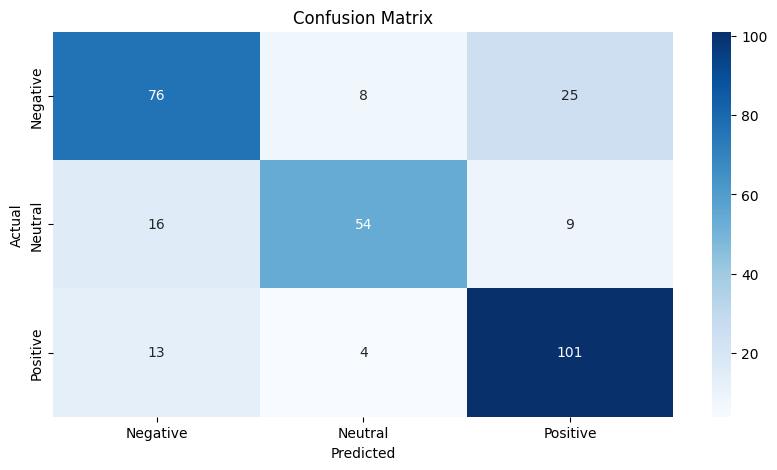

In [51]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    """
    Preprocess text data.

    Args:
        text (str): Input text.

    Returns:
        str: Preprocessed text.
    """
    lemmatizer = WordNetLemmatizer()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    text = ' '.join(words)
    return text

def vectorize(text, model):
    """
    Vectorize text data using a FastText model.

    Args:
        text (str): Input text.
        model: Trained FastText model.

    Returns:
        np.array: Vectorized representation of the input text.
    """
    words = text.split()
    word_vectors = [model.get_word_vector(word) for word in words]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.get_dimension())

def youdens_index(y_true, y_pred):
    """
    Calculate Youden's Index.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        float: Youden's Index.
    """
    cm = confusion_matrix(y_true, y_pred)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    return sensitivity + specificity - 1

def test_fasttext_svm(new_dataset_path, text_column, label_column, fasttext_model_path):
    """
    Test FastText model with SVM classifier.

    Args:
        new_dataset_path (str): Path to the new dataset CSV file.
        text_column (str): Column name for text data.
        label_column (str): Column name for label data.
        fasttext_model_path (str): Path to the trained FastText model file.

    Returns:
        None
    """
    dataset = pd.read_csv(new_dataset_path, sep=";")
    dataset.dropna(subset=[label_column], inplace=True)
    texts = dataset[text_column].tolist()
    labels = dataset[label_column].tolist()
    texts = [preprocess_text(text) for text in texts]
    labels = [f'__label__{int(label)}' for label in labels]
    model = fasttext.load_model(fasttext_model_path)
    X = [vectorize(text, model) for text in texts]
    y = [int(label.replace('__label__', '')) for label in labels]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
    }

    svm_classifier = svm.SVC()
    grid_search = GridSearchCV(estimator=svm_classifier, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_svm_classifier = grid_search.best_estimator_

    scores = cross_val_score(best_svm_classifier, X, y, cv=5, scoring='accuracy')
    print(f"Cross-validation scores: {scores}")
    print(f"Mean cross-validation score: {np.mean(scores)}")

    y_pred = cross_val_predict(best_svm_classifier, X, y, cv=5)

    print("\nPerformance metrics on the entire dataset:")
    print(classification_report(y, y_pred))
    print(f"Cohen's Kappa: {cohen_kappa_score(y, y_pred)}")
    print(f"Youden's Index: {youdens_index(y, y_pred)}")

    conf_matrix = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def upload(file_path):
    """
    Load data from a CSV file.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        str: Full path to the downloaded file.
    """
    folder_id = '1DMy1eWI-45E-N08ez_7r5PMcu4Hk-YJC'  # Aqui é o id da pasta
    url = f'https://drive.google.com/drive/folders/{folder_id}?usp=sharing'
    gdown.download_folder(url, quiet=False, use_cookies=False)
    file_path_full = os.path.join("Grupo1", file_path)  # Ajuste para procurar na subpasta "Grupo1"
    if os.path.exists(file_path_full):
        return file_path_full
    else:
        raise FileNotFoundError(f"O arquivo {file_path} não foi encontrado na pasta do Google Drive.")

# Load new dataset and test the FastText model with SVM classifier
new_dataset_path = upload("new_dataset.csv")
text_column = 'comment'
label_column = 'sentiment'
fasttext_model_path = 'fasttext_model_hs.bin'
test_fasttext_svm(new_dataset_path, text_column, label_column, fasttext_model_path)


### **Conclusion**
The results indicate that the FastText+SVM model performs well, with good accuracy and balance between precision and recall across different classes. The use of advanced preprocessing techniques, class balancing, and hyperparameter tuning contributed to the model's improved performance. However, there is room for further improvement, especially in distinguishing between the negative and neutral classes.







